In [1]:
import os
import sys
import glob
import pygmt
import obspy
from obspy.taup import TauPyModel
import numpy as np
import math


# initial working directory
init_dir = os.getcwd()

# improvement in obspy.taup_pierce
def turn_in_pierce_geo(source_depth_in_km, source_lat_in_deg, source_lon_in_deg, 
                       receiver_lat_in_deg, receiver_lon_in_deg, phase_list=('S',), 
                       model='prem'):
    # calculate pierce
    model = TauPyModel(model=model)
    arrivals = model.get_pierce_points_geo(source_depth_in_km, source_lat_in_deg, 
                                           source_lon_in_deg, receiver_lat_in_deg, 
                                           receiver_lon_in_deg, phase_list)
    arrival = arrivals[0]
    
    # index in arrival and depth of turn point
    index, turn_depth = -1, 0.0
    for ray_param, travl_time, epic_dist, depth, lat, lon in arrival.pierce:
        index += 1
        if depth > turn_depth:
            turn_depth = depth
            turn_index = index
    if index == -1:
        sys.exit('No turn point of %s!' % phase_list)
    turn_ray_param, turn_time, turn_dist, turn_depth, turn_lat, turn_lon \
    = arrival.pierce[turn_index]
    
    return turn_depth, turn_lat, turn_lon

# plot turn points of the seismic data set
def plot_turnpoints(dirname, fnames, color, fig, phase_list):
    if os.path.exists(dirname):
        os.chdir(dirname)
    else:
        sys.exit('No %s!' % dirname)
    for fname in glob.glob(fnames):
        tr = obspy.read(fname)[0]
        evla, evlo = tr.stats.sac['evla'], tr.stats.sac['evlo']
        stla, stlo = tr.stats.sac['stla'], tr.stats.sac['stlo']
        evdp = tr.stats.sac['evdp']
        try:
            turn_depth, turn_lat, turn_lon \
            = turn_in_pierce_geo(evdp, evla, evlo, stla, stlo, phase_list)
        except ValueError:
            print('No turn point of %s!' % phase_list[0])
        else:
            # turn points
            pen1 = "1p,%s,solid" % color
            fig.plot(
                pen=pen1,
                style="c0.2c",
                x=turn_lon,
                y=turn_lat,
            )
            # receiver points
            pen3 = "1p,%s,solid" % color
            fig.plot(
                style="t0.2c",
                pen=pen3,
                x=stlo,
                y=stla,
            )
    # source point
    pen2 = "1p,%s,solid" % color
    fig.plot(
        pen=pen2,
        style="a0.5c",
        x=evlo,
        y=evla,
    )
        
    return

def GyPSuM_map(ncfile, fig, region, projection='M15c'):
    if not(os.path.exists(ncfile)):
        sys.exit('No such file: %s!' % ncfile)
    else:
        ncfile = ncfile + '?dvs(2800)'
    pygmt.grd2cpt(
        grid=ncfile,
        cmap='seis',
        background=True,
    )
    # plotting GyPSuM
    fig.basemap(
        frame="a",
        projection=projection,
        region=region,
    )
    fig.grdimage(
        grid=ncfile,
        dpi=500,
        frame="a",
    )
    fig.colorbar(
        position="jCR+w10c/0.5c+o-1c/0c+m",
        frame=['xa1f0.5', 'y+l"dVs"'],
    )
    fig.coast(
        shorelines="0.5p,black",
        borders="1/1p",
        area_thresh="1000",
    )
    
    return

# get turn points lists of the seismic data set
def get_turnpoints(dirname, fnames, phase_list):
    if os.path.exists(dirname):
        os.chdir(dirname)
    else:
        sys.exit('No %s!' % dirname)
    
    turn_depths, turn_lats, turn_lons = [], [], []
    for fname in glob.glob(fnames):
        tr = obspy.read(fname)[0]
        evla, evlo = tr.stats.sac['evla'], tr.stats.sac['evlo']
        stla, stlo = tr.stats.sac['stla'], tr.stats.sac['stlo']
        evdp = tr.stats.sac['evdp']
        try:
            turn_depth, turn_lat, turn_lon \
            = turn_in_pierce_geo(evdp, evla, evlo, stla, stlo, phase_list)
        except ValueError:
            print('No turn point of %s!' % phase_list[0])
        else:
            turn_depths.append(turn_depth)
            turn_lats.append(turn_lat)
            turn_lons.append(turn_lon)
        
    return turn_depths, turn_lats, turn_lons

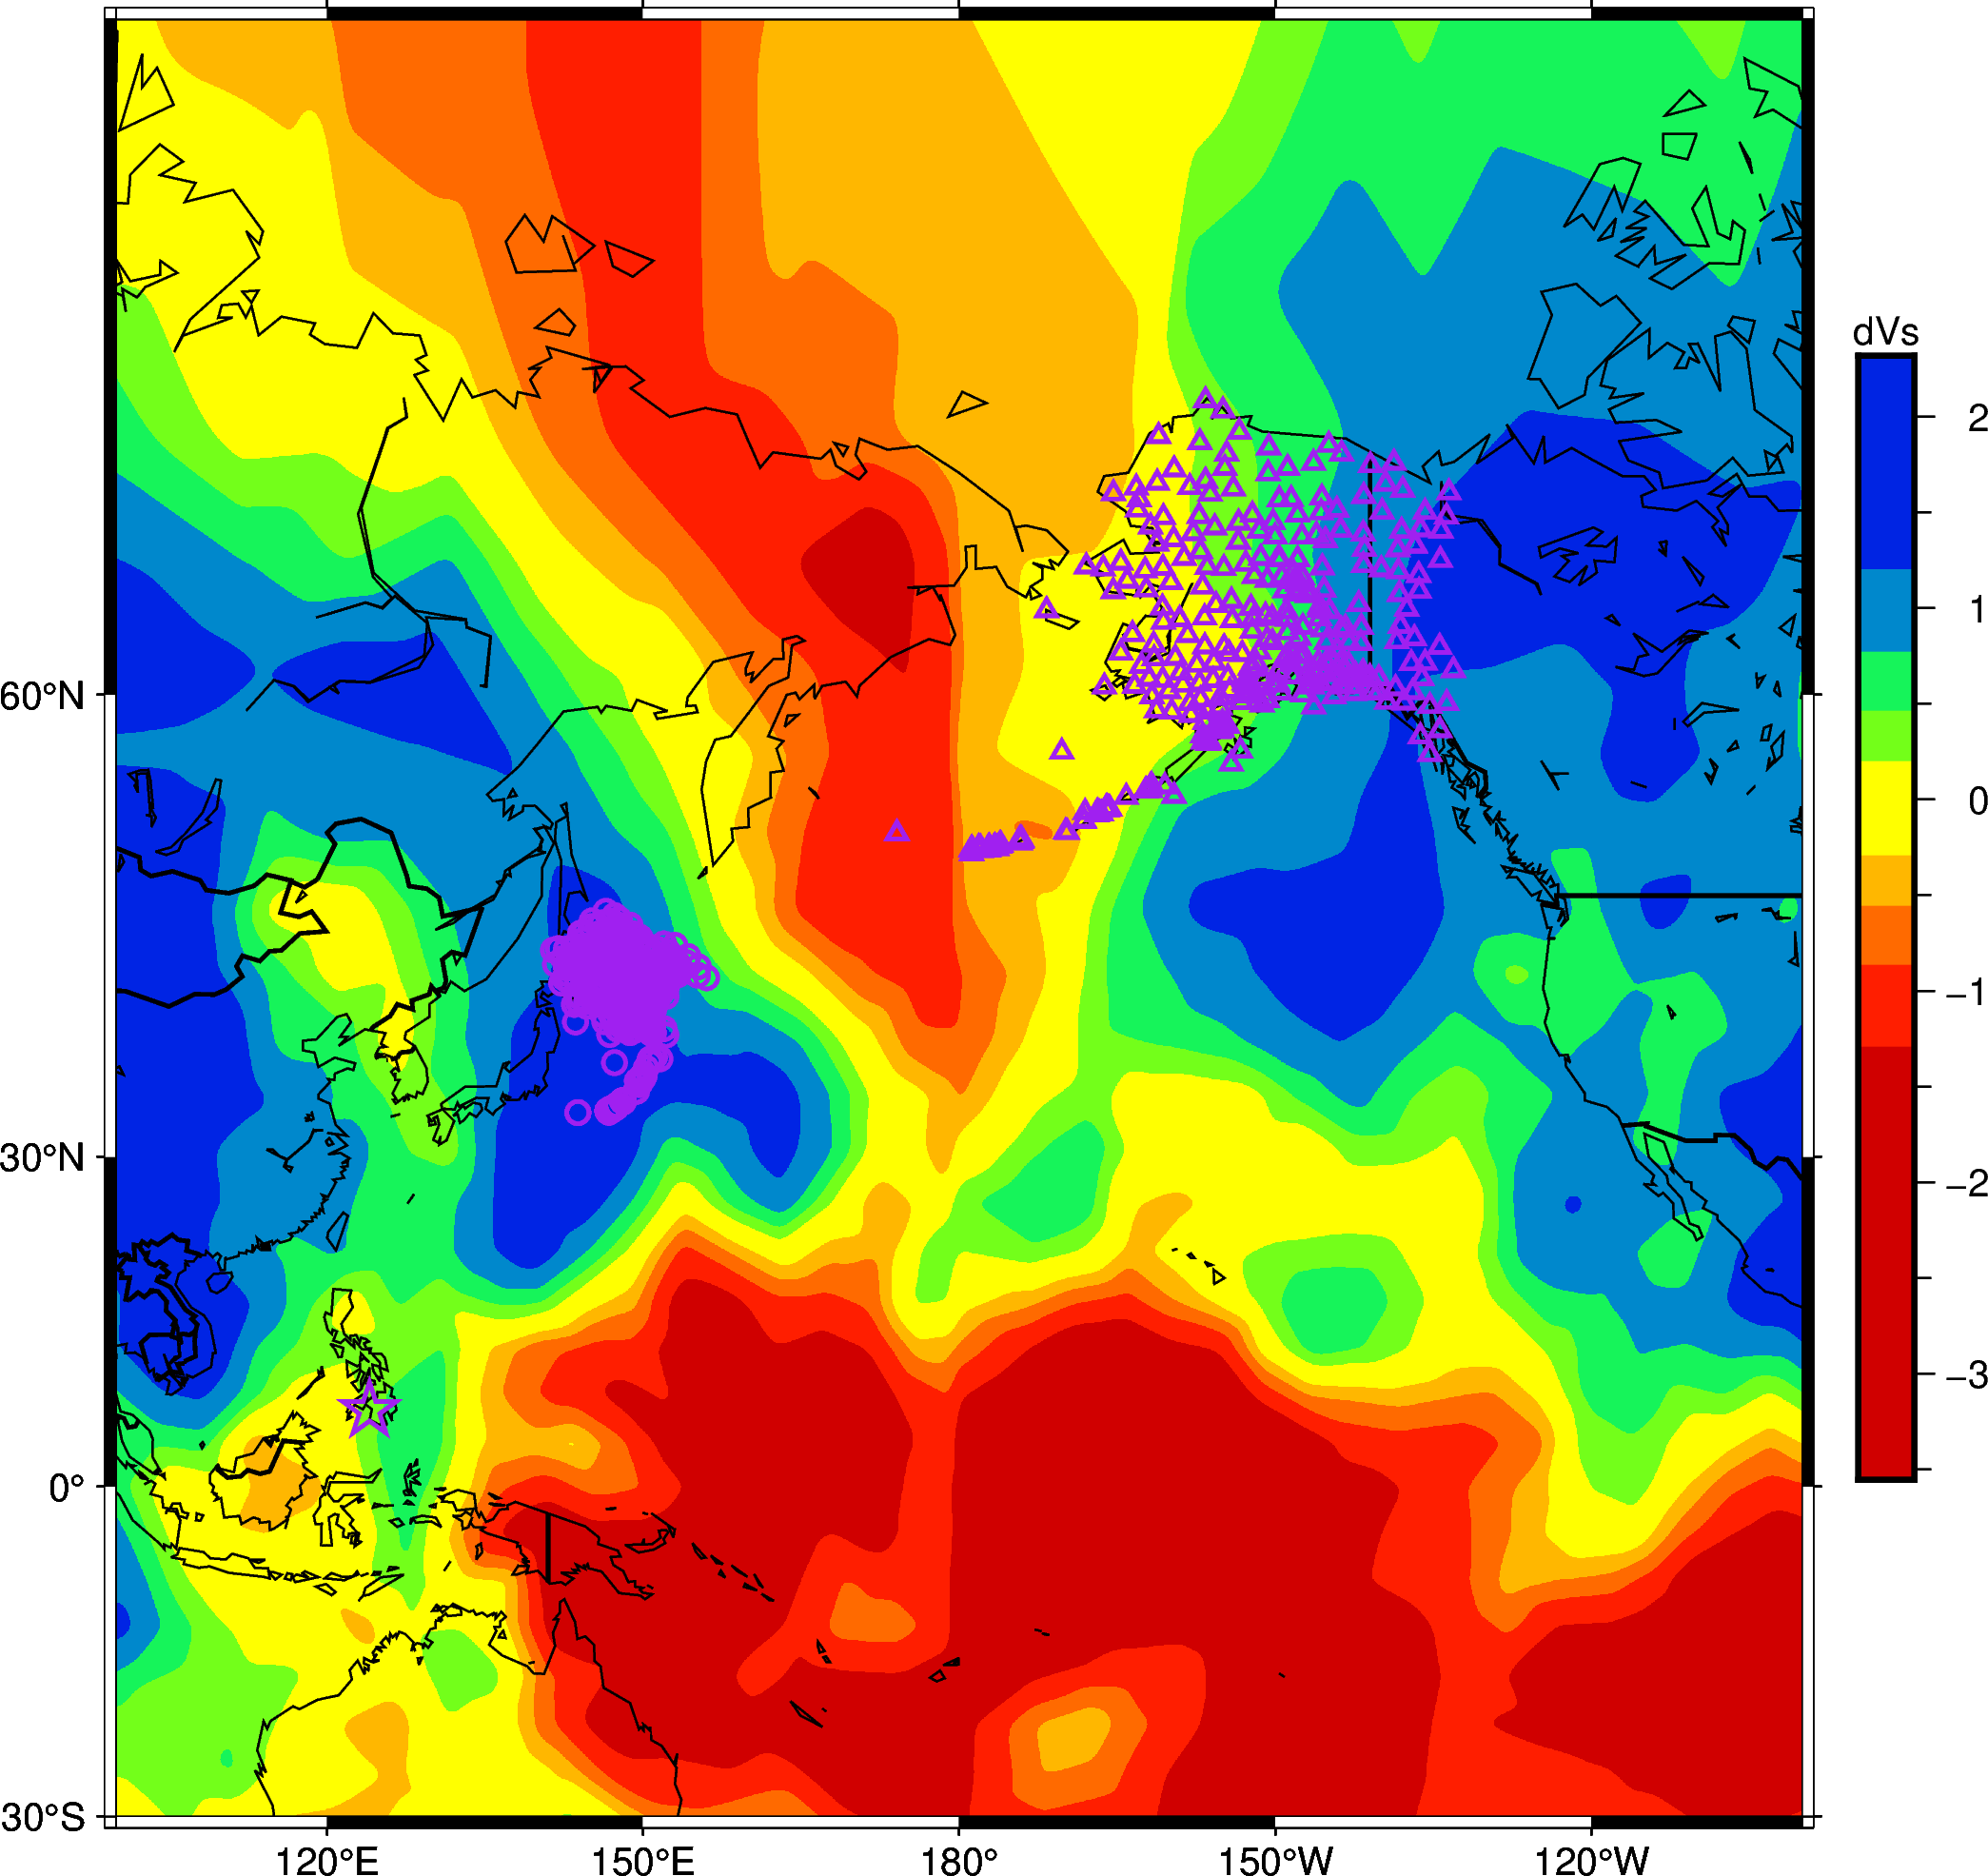

In [2]:

fig = pygmt.Figure()

# interesting region
region = [100, 260, -30, 80]

ncfile = '/home/sheng/GyPSuM/GYPSUM_percent.nc'
GyPSuM_map(ncfile=ncfile, fig=fig, region=region)


# map out the turn points, stations, and source
plot_turnpoints(dirname='/home/sheng/zscd/target/20200801/sac1', \
                fnames='*.BHT', color='purple', fig=fig, \
                phase_list=('sS',))
#plot_turnpoints(dirname='/home/sheng/zscd/previous/20181104/sac1', \
 #               fnames='*.BHT', color='cyan', fig=fig, \
  #              phase_list=('S',))
#plot_turnpoints(dirname='/home/sheng/zscd/previous/20170520/sac1', \
 #               fnames='*.BHT', color='red', fig=fig, \
  #              phase_list=('S',))

# back to initial working directory
os.chdir(init_dir)

fig.show()
#fig.savefig('sS214_140S.png')

/home/sheng/zscd/seek/20210929/sac1


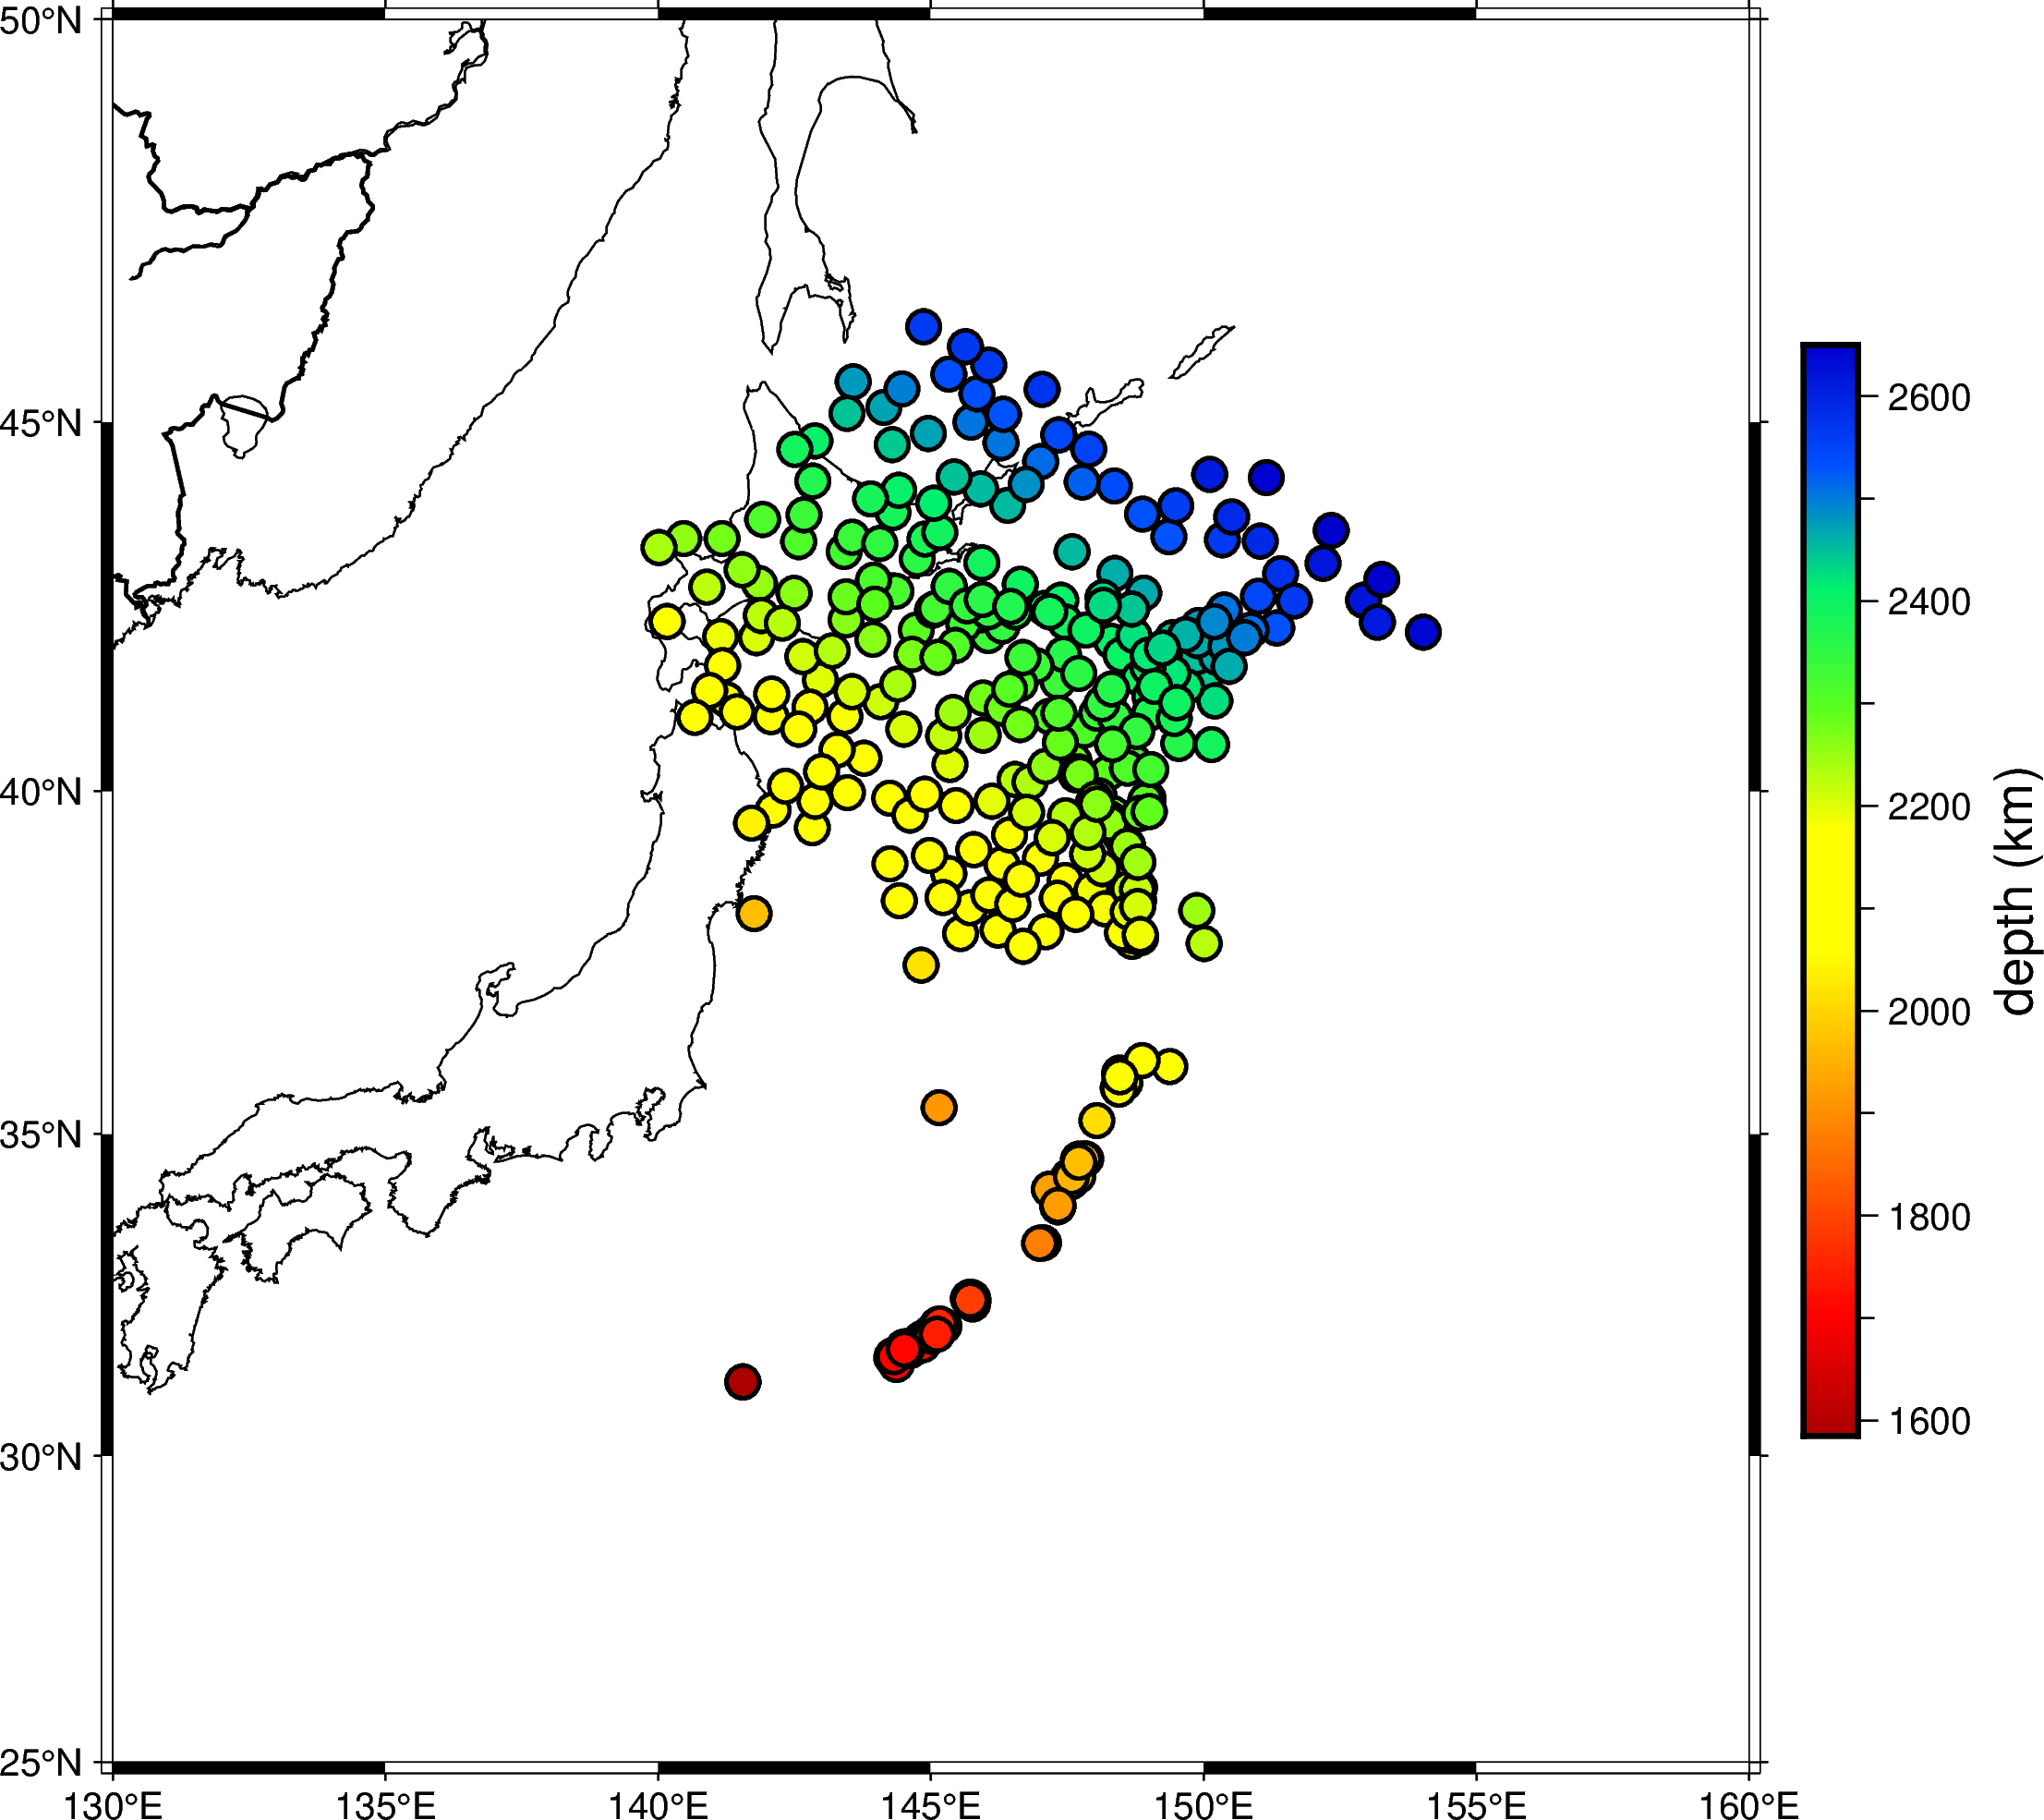

In [133]:

turn_depths, turn_lats, turn_lons \
= get_turnpoints(dirname='/home/sheng/zscd/previous/20200801/sac1', \
                 fnames='*.BHT', phase_list=('S',))

fg = pygmt.Figure()

region, series = [130, 160, 25, 50], []

series.append(min(turn_depths))
series.append(max(turn_depths))

pygmt.makecpt(
    series=series,
    cmap="seis",
    background=True,
)
fg.basemap(
    projection="M15c",
    region=region,
    frame="a",
)
fg.coast(
    shorelines="0.5p,black",
    borders="1/1p",
    area_thresh="1000",
)
fg.plot(
    x=turn_lons,
    y=turn_lats,
    pen="1p,black,solid",
    style="c0.3c",
    cmap=True,
    color=turn_depths,
)
fg.colorbar(
    position="jCR+w10c/0.5c+o-1c/0c+m",
    frame='xaf+l"depth (km)"'
)

os.chdir(init_dir)

fg.show()
#fg.savefig("20200801_turnpoint_depth.png")

In [16]:

fig = pygmt.Figure()

# interesting region
region = [100, 260, -30, 80]

ncfile = '/home/sheng/GyPSuM/GYPSUM_percent.nc'
GyPSuM_map(ncfile=ncfile, fig=fig, region=region)


# map out the turn points, stations, and source
plot_turnpoints(dirname='/home/sheng/zscd/seek/20190727/sac1', \
                fnames='*.BHT', color='purple', fig=fig, \
                phase_list=('S',))
center = [137.33, 33.15]
length = [0, 65]
# project
points = pygmt.project(center=center, azimuth=40, \
                       length=length, generate=0.1)
fig.plot(x=points.r, y=points.s, style="c0.05c", \
         pen='0.2p,cyan,solid')

points = pygmt.project(center=center, azimuth=24, \
                       length=length, generate=0.1)
fig.plot(x=points.r, y=points.s, style="c0.05c", \
         pen='0.2p,cyan,solid')

points = pygmt.project(center=center, azimuth=28, \
                       length=length, generate=0.1)
fig.plot(x=points.r, y=points.s, style="c0.05c", \
         pen='0.2p,cyan,solid')

points = pygmt.project(center=center, azimuth=32, \
                       length=length, generate=0.1)
fig.plot(x=points.r, y=points.s, style="c0.05c", \
         pen='0.2p,cyan,solid')

points = pygmt.project(center=center, azimuth=36, \
                       length=length, generate=0.1)
fig.plot(x=points.r, y=points.s, style="c0.05c", \
         pen='0.2p,cyan,solid')

# back to initial working directory
os.chdir('/home/sheng/zscd/ipynb')

#fig.show()
fig.savefig('project2019.png')

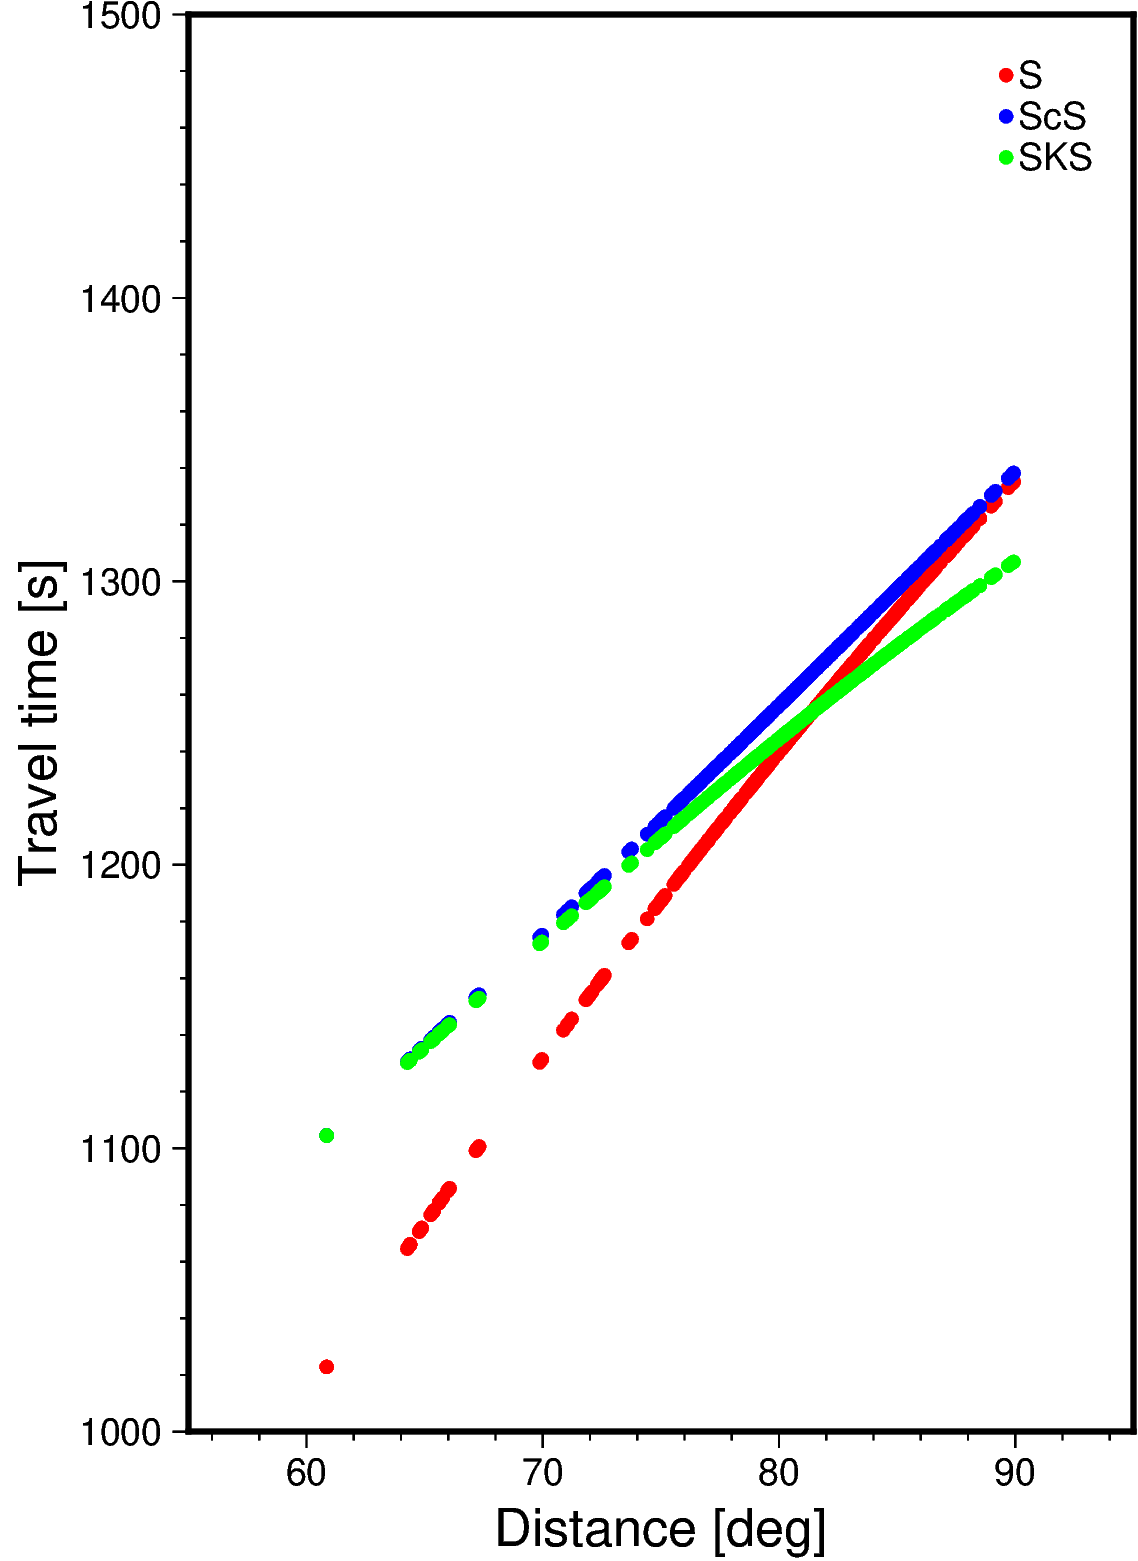

In [65]:
import os
import sys
import obspy
import glob
import pygmt
from obspy.taup import TauPyModel

def map_gc_and_travel(dirname, fnames, phase, fig, color, model='prem'):
    if os.path.exists(dirname):
        os.chdir(dirname)
    else:
        sys.exit('No such dir: %s!' % dirname)
        
    model = TauPyModel(model=model)
    gcs, travels = [], []
    for fname in glob.glob(fnames):
        tr = obspy.read(fname)[0]
        gc, evdp = tr.stats.sac['gcarc'], tr.stats.sac['evdp']
        
        arrivals = model.get_travel_times(evdp, gc, phase_list=(phase,))
        try:
            arrival = arrivals[0]
        except IndexError:
            continue
        else:
            travels.append(arrival.time)
            gcs.append(gc)
    fig.plot(
        x=gcs,
        y=travels,
        style='c0.1c',
        color=color,
        pen='0.5p,%s' % color,
        label=phase,
    )
    
    return

fig = pygmt.Figure()

fig.basemap(
    projection='X8c/12c',
    region=[55, 95, 1000, 1500],
    frame=['xa10f2+l"Distance [deg]"', 'ya100f20+l"Travel time [s]"'],
)

map_gc_and_travel(dirname='/home/sheng/zscd/target/20200801/sac1', fnames='*.BHT', 
                  phase='S', color='red', fig=fig)
map_gc_and_travel(dirname='/home/sheng/zscd/target/20200801/sac1', fnames='*.BHT', 
                  phase='ScS', color='blue', fig=fig)
map_gc_and_travel(dirname='/home/sheng/zscd/target/20200801/sac1', fnames='*.BHT', 
                  phase='SKS', color='green', fig=fig)

fig.legend(box=False)

fig.show()

In [6]:
import pygmt
import numpy as np
from obspy.taup import TauPyModel


def get_cross_profile(start, az, line_inc, len_list, grid, 
                      newcolname, fig, depth_inc=5, outgrid='cross.nc'):
    # generate a line from start point and azimuth, length
    points = pygmt.project(
        center=start,
        azimuth=az,
        generate='%dd' % line_inc,
        length=len_list,
    )
    # derive the cross section profile
    with open(outgrid[:-3], 'w') as fo:
        d_max = 2900 + depth_inc
        for depth in np.arange(0, d_max, depth_inc):
            track = pygmt.grdtrack(
                points=points,
                grid='%s?%s(%s)' % (grid, newcolname, depth),
                newcolname=newcolname,
            )
            for i in range(len(track.p)):
                fo.write('%s %s %s\n' % (track.p[i], depth, track.dvs[i]))
    pygmt.xyz2grd(
        data=outgrid[:-3],
        outgrid=outgrid,
        spacing='%s/%s' % (line_inc, depth_inc),
        region=[len_list[0], len_list[1], 0, 2900],
    )
    pygmt.grd2cpt(
        grid=outgrid,
        cmap='seis',
    )
    fig.grdimage(
        grid=outgrid,
        dpi=500,
    )
    
    return

def ray_in_cross_section(fig, phase, pen, evdp, gc_list=[], 
                         model='prem', source=True, receiver=True):
    deg_per = 180 / np.pi
    model = TauPyModel(model=model)
    for gc in gc_list:
        arrivals = model.get_ray_paths(evdp, gc, phase_list=(phase,))
        try:
            arrival = arrivals[0]
        except IndexError:
            continue
        else:
            fig.plot(
                x=arrival.path['dist']*deg_per,
                y=arrival.path['depth'],
                pen=pen,
            )
        # source location
        if source:
            fig.plot(
                x=0,
                y=evdp,
                style='a0.5c',
                color='red',
                pen='0.3p,red',
                no_clip='r',
            )
        # receiver location
        if receiver:
            fig.plot(
                x=gc,
                y=0,
                style='c0.2c',
                color='yellow',
                pen='0.3p,yellow',
                no_clip='r',
            )
    
    return

In [34]:
fig = pygmt.Figure()

fig.basemap(
    projection="P15c+a+t45+fp",
    region=[0, 90, 0, 2900],
    frame=['af', 'y+l"Depth[km]"', 'WSrN'],
)
get_cross_profile(start='124.05/7.26', az=38, line_inc=1, len_list=[0, 90], 
                  grid='GYPSUM_percent.nc', newcolname='dvs', fig=fig)
ray_in_cross_section(fig=fig, phase='ScS', pen='0.5p,black', evdp=492.4, 
                     gc_list=[65, 70, 75, 80, 85, 90], source=True, receiver=True)
ray_in_cross_section(fig=fig, phase='S', pen='0.5p,purple', evdp=492.4, 
                     gc_list=[65, 70, 75, 80, 85, 90], source=False, receiver=False)
fig.colorbar(
    position='jBC+w5c/0.4c+o0c/-0.5c+m',
    frame='xa1f0.5+l"dVs (%)"',
)

#fig.show()
fig.savefig('cross38.png')

In [55]:
import os
import sys
import obspy
import pygmt
import glob


def station_map(dirname, f_index, fig):
    if os.path.exists(dirname):
        os.chdir(dirname)
    else:
        sys.exit('No such dir: %s!' % dirname)
    for fname in glob.glob(f_index):
        tr = obspy.read(fname)[0]
        stlo, stla = tr.stats.sac['stlo'], tr.stats.sac['stla']
        knetwk, kstnm = tr.stats.sac['knetwk'], tr.stats.sac['kstnm']
        
        fig.plot(
            x=stlo,
            y=stla,
            style='i0.2c',
            color='yellow',
            pen='0.5p,yellow',
        )
        fig.text(
            x=stlo,
            y=stla,
            text='%s.%s' % (knetwk, kstnm),
            font='12p,Helvetica-Bold,red',
        )
    
    return

fig = pygmt.Figure()

fig.basemap(
    projection='M20c',
    region=[180, 230, 50, 72],
    frame='a'
)
fig.coast(
    shorelines="0.5p,black",
    borders="1/1p",
    area_thresh="1000",
)
station_map(dirname='/home/sheng/zscd/seek/20210929/sac1', f_index='*.BHT', fig=fig)
fig.plot(
    x=[200, 220, 220, 200, 200],
    y=[55, 55, 65, 65, 55],
    pen='1p,blue',
)

#fig.show()
#fig.savefig('station.png')
fg = pygmt.Figure()

fg.basemap(
    projection='M20c',
    region=[200, 220, 55, 65],
    frame='a'
)
fg.coast(
    shorelines="0.5p,black",
    borders="1/1p",
    area_thresh="1000",
)
station_map(dirname='/home/sheng/zscd/seek/20210929/sac1', f_index='*.BHT', fig=fg)

#fg.show()
os.chdir('/home/sheng/zscd/ipynb')
fig.savefig('station2021.png')
fg.savefig('station2021sub.png')

In [57]:
fig = pygmt.Figure()

fig.basemap(
    projection='M20c',
    region=[180, 230, 50, 72],
    frame='a'
)
fig.coast(
    shorelines="0.5p,black",
    borders="1/1p",
    area_thresh="1000",
)
station_map(dirname='/home/sheng/zscd/target/20200801/sac1', f_index='*.BHT', fig=fig)
fig.plot(
    x=[200, 220, 220, 200, 200],
    y=[55, 55, 65, 65, 55],
    pen='1p,blue',
)

#fig.show()
#fig.savefig('station.png')
fg = pygmt.Figure()

fg.basemap(
    projection='M20c',
    region=[200, 220, 55, 65],
    frame='a'
)
fg.coast(
    shorelines="0.5p,black",
    borders="1/1p",
    area_thresh="1000",
)
station_map(dirname='/home/sheng/zscd/target/20200801/sac1', f_index='*.BHT', fig=fg)

#fg.show()
os.chdir('/home/sheng/zscd/ipynb')
fig.savefig('station2020.png')
fg.savefig('station2020sub.png')

In [58]:
import obspy
tr = obspy.read('/home/sheng/zscd/seek/20210929/sac1/2021.272.08.44.13.000.AT.SKAG..BHT')[0]

tr.stats

         network: AT
         station: SKAG
        location: 
         channel: BHT
       starttime: 2021-09-29T08:44:13.100014Z
         endtime: 2021-09-29T09:06:12.900014Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 52793
           calib: 6.2914e+08
         _format: SAC
             sac: AttribDict({'delta': 0.025, 'depmin': -3198.6943, 'depmax': 3620.2527, 'scale': 6.2913997e+08, 'b': 427.50201, 'e': 1747.302, 'o': 0.0, 't1': 548.95001, 't2': 994.95001, 'stla': 59.460098, 'stlo': -135.32896, 'stel': 134.0, 'stdp': 0.0, 'evla': 38.91, 'evlo': 135.22, 'evdp': 371.19, 'dist': 6353.8008, 'az': 37.407169, 'baz': 291.86209, 'gcarc': 57.204399, 'depmen': -0.041882582, 'cmpaz': 201.86206, 'cmpinc': 90.0, 'nzyear': 2021, 'nzjday': 272, 'nzhour': 8, 'nzmin': 37, 'nzsec': 5, 'nzmsec': 598, 'nvhdr': 6, 'npts': 52793, 'iftype': 1, 'idep': 6, 'iztype': 11, 'leven': 1, 'lpspol': 1, 'kstnm': 'SKAG', 'kevnm': 'Sea Of Japan', 'kt1': 'P', 'kt2': 'S', 'kcmpnm': 'BHT', 'knetwk'